In [1]:
from IPython.display import clear_output

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

from keras.models import Model
from keras.layers import Input, Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras import backend as K
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import load_model, save_model
from keras import regularizers
from keras.optimizers import RMSprop, Adam
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint
from keras.callbacks import EarlyStopping, LearningRateScheduler
from keras.callbacks import Callback

Using TensorFlow backend.


## Functions

In [2]:
def create_model():
    input_layer = Input(shape=input_shape)
    conv2d_1 = Conv2D(32, kernel_size=3, activation='relu', input_shape=input_shape)(input_layer)
    batch_norm_1 = BatchNormalization()(conv2d_1)
    conv2d_2 = Conv2D(32, kernel_size=3, activation='relu')(batch_norm_1)
    batch_norm_2 = BatchNormalization()(conv2d_2)
    conv2d_3 = Conv2D(32, kernel_size=5, strides=2, padding='same', activation='relu')(batch_norm_2)
    batch_norm_3 = BatchNormalization()(conv2d_3)
    dropout_1 = Dropout(0.4)(batch_norm_3)
    conv2d_4 = Conv2D(64, kernel_size=3, activation='relu')(dropout_1)
    batch_norm_4 = BatchNormalization()(conv2d_4)
    conv2d_5 = Conv2D(64, kernel_size=3, activation='relu')(batch_norm_4)
    batch_norm_5 = BatchNormalization()(conv2d_5)
    conv2d_6 = Conv2D(64, kernel_size=5, strides=2, padding='same', activation='relu')(batch_norm_5)
    batch_norm_6 = BatchNormalization()(conv2d_6)
    dropout_2 = Dropout(0.4)(batch_norm_6)
    conv2d_7 = Conv2D(128, kernel_size=4, activation='relu')(dropout_2)
    batch_norm_7 = BatchNormalization()(conv2d_7)
    conv2d_8 = Conv2D(128, kernel_size=4, activation='relu')(dropout_2)
    batch_norm_8 = BatchNormalization()(conv2d_8)
    flatten_1 = Flatten()(batch_norm_8)
    dropout_2 = Dropout(0.4)(flatten_1)
    output_1 = Dense(10, activation='softmax')(dropout_2)
    output_2 = Dense(10, activation='softmax')(dropout_2)
    model = Model(inputs=[input_layer], outputs=[output_1, output_2] )
   
    print(model.summary())
    
    plot_model(model, to_file='two_digit_mnist.png')
    plt.figure(figsize=(20, 20))
    img = mpimg.imread('two_digit_mnist.png')
    plt.imshow(img)
    
    model.compile(optimizer="adam",
                  loss=["categorical_crossentropy","categorical_crossentropy"],
                  metrics=["accuracy", 'accuracy'])
    return model

In [3]:
class PlotLearning(Callback):
    """Plot fit metrics during training"""
    
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.loss = []
        self.val_loss = []
        self.dense_1_accuracy = []
        self.dense_2_accuracy = []
        self.val_dense_1_accuracy = []
        self.val_dense_2_accuracy = []
        self.dense_1_loss = []
        self.dense_2_loss = []
        self.val_dense_1_loss = []
        self.val_dense_2_loss = []
        self.learning_rate = []
        #self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.i += 1
        self.logs.append(logs)
        self.x.append(self.i)
        self.loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))
        self.dense_1_loss.append(logs.get('dense_1_loss'))
        self.val_dense_1_loss.append(logs.get('val_dense_1_loss'))
        self.dense_2_loss.append(logs.get('dense_2_loss'))
        self.val_dense_2_loss.append(logs.get('val_dense_2_loss'))
        self.dense_1_accuracy.append(logs.get('dense_1_accuracy'))
        self.val_dense_1_accuracy.append(logs.get('val_dense_1_accuracy'))
        self.dense_2_accuracy.append(logs.get('dense_2_accuracy'))
        self.val_dense_2_accuracy.append(logs.get('val_dense_2_accuracy'))
        self.learning_rate.append(logs.get('lr'))

        f, (ax1, ax2) = plt.subplots(2, 3, sharex=True, figsize=(14, 9))
        
        clear_output(wait=True)
        
        ax1[0].plot(self.x, self.loss, label="Loss")
        ax1[0].plot(self.x, self.val_loss, label="Valid_loss")
        ax1[0].set_xlabel('Epoch')
        ax1[0].legend()
        
        ax1[1].plot(self.x, self.dense_1_loss, label="Digit_1_loss")
        ax1[1].plot(self.x, self.val_dense_1_loss, label="Valid_loss")
        ax1[1].set_xlabel('Epoch')
        ax1[1].legend()
        
        ax1[2].plot(self.x, self.dense_2_loss, label="Digit_2_loss")
        ax1[2].plot(self.x, self.val_dense_2_loss, label="Valid_loss")
        ax1[2].set_xlabel('Epoch')
        ax1[2].legend()
        
        ax2[0].plot(self.x, self.learning_rate)
        ax2[0].set_yscale('log')
        ax2[0].set_xlabel('Epoch')
        ax2[0].set_ylabel('Learning rate')
        
        ax2[1].plot(self.x, self.dense_1_accuracy, label="Digit_1_acc")
        ax2[1].plot(self.x, self.val_dense_1_accuracy, label="Valid_acc")
        ax2[1].set_xlabel('Epoch')
        ax2[1].legend()
        
        ax2[2].plot(self.x, self.dense_2_accuracy, label="Digit_2_acc")
        ax2[2].plot(self.x, self.val_dense_2_accuracy, label="Valid_acc")
        ax2[2].set_xlabel('Epoch')
        ax2[2].legend()
        
        plt.show();

In [4]:
def create_callbacks():
    reduce_learning_rate = ReduceLROnPlateau(monitor='val_loss', 
                                         patience=3, 
                                         verbose=1, 
                                         factor=0.8, 
                                         min_lr=1e-10)
              
    #reduce_learning_rate = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
              
    checkpoint = ModelCheckpoint('mnist_weights.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True,
                             mode='max')
              
    early_stopping = EarlyStopping(monitor='val_loss',
                               min_delta=1e-8,
                               patience=50, 
                               verbose=1,
                               restore_best_weights=True)
    
    plot_callback = PlotLearning()

    callbacks = [reduce_learning_rate, checkpoint, early_stopping, plot_callback]
    return callbacks

In [5]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(2, 3, figsize=(14, 9))
   
    ax1[0].plot(df_history[['loss', 'val_loss']])
    ax1[0].set_xlabel('Epoch')
    ax1[0].legend(['loss', 'val_loss'])
    
    ax1[1].plot(df_history[['dense_1_loss', 'val_dense_1_loss']])
    ax1[1].set_xlabel('Epoch')
    ax1[1].legend(['dense_1_loss', 'val_dense_1_loss'])
    
    ax1[2].plot(df_history[['dense_2_loss', 'val_dense_2_loss']])
    ax1[2].set_xlabel('Epoch')
    ax1[2].legend(['dense_2_loss', 'val_dense_2_loss'])
    
    ax2[0].plot(df_history['lr'])
    ax2[0].set_xlabel('Epoch')
    ax2[0].set_ylabel('Learning rate')
    
    ax2[1].plot(df_history[['dense_1_accuracy', 'val_dense_1_accuracy']])
    ax2[1].set_xlabel('Epoch')
    ax2[1].legend(['dense_1_acc', 'val_dense_1_acc'])
    
    ax2[2].plot(df_history[['dense_2_accuracy', 'val_dense_2_accuracy']])
    ax2[2].set_xlabel('Epoch')
    ax2[2].legend(['dense_2_acc', 'val_dense_2_acc'])

In [6]:
def confusion_matrix_analysis(y_test, y_pred_1, y_pred_2):
    """Compute and plot the confusion matrix for each digit"""
    
    conf_mat_1 = confusion_matrix(y_test.iloc[:, 0], y_pred_1)
    conf_mat_2 = confusion_matrix(y_test.iloc[:, 1], y_pred_2)

    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    sns.heatmap(conf_mat_1, annot=True, square=True, ax=ax[0])
    sns.heatmap(conf_mat_2, annot=True, square=True, ax=ax[1])
    ax[0].set_title('Confusion Matrix - Digit 1')
    ax[0].set_xlabel('y_test')
    ax[0].set_ylabel('y_predict')
    ax[1].set_title('Confusion Matrix - Digit 2')
    ax[1].set_xlabel('y_test')
    ax[1].set_ylabel('y_predict')
    plt.tight_layout()
    #plt.subplot_tool()
    
    return conf_mat_1, conf_mat_2

In [7]:
def plot_sample_images():
    n_rows = 1
    n_cols = 5
    random_index = np.random.randint(0, df_train.shape[0], size=n_cols)
    fig, ax = plt.subplots(n_rows, n_cols, figsize=(18, 5))
    for i in range(n_cols):
            fig.add_subplot(n_rows, n_cols, i+1)
            plt.imshow(df_train.iloc[random_index[i], :].values.reshape(42, 28))
    plt.tight_layout()

## Main Code

In [8]:
# Parameters
input_shape = [42, 28, 1]
batch_size = 32
epochs = 100

In [9]:
df_train = pd.read_csv('../input/two-digit-mnist/two_digit_mnist_xtrain.csv', index_col=0)
df_test = pd.read_csv('../input/two-digit-mnist/two_digit_mnist_xtest.csv', index_col=0)
y_train = pd.read_csv('../input/two-digit-mnist/two_digit_mnist_ytrain.csv', index_col=0).T
y_test = pd.read_csv('../input/two-digit-mnist/two_digit_mnist_ytest.csv', index_col=0).T
print('Training data shape: {}, testing data shape: {}'.format(df_train.shape, df_test.shape))
print('Training labels shape: {}, testing labels shape: {}'.format(y_train.shape, y_test.shape))

Training data shape: (40000, 1176), testing data shape: (4000, 1176)
Training labels shape: (40000, 2), testing labels shape: (4000, 2)


In [10]:
y_train.head()

,0,1
0,2.0,2.0
1,8.0,4.0
2,6.0,5.0
3,6.0,4.0
4,5.0,2.0


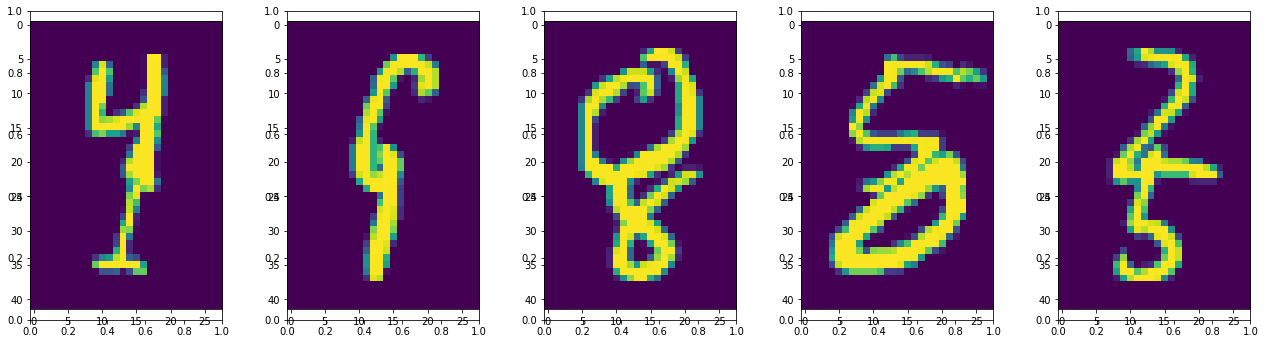

In [11]:
# Randomly select five images and show them
plot_sample_images()

In [12]:
# Data scaling and reshaping
X_train = (df_train.values/255.0).reshape([-1, 42, 28, 1])
X_test = (df_test.values/255.0).reshape([-1, 42, 28, 1])

In [13]:
# Prepare two separate one-hot encoded y vectors for fitting
y_train_digit_1 = to_categorical(y_train.iloc[:, 0])
y_train_digit_2 = to_categorical(y_train.iloc[:, 1])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 42, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 40, 26, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 40, 26, 32)   128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 38, 24, 32)   9248        batch_normalization_1[0][0]      
____________________________________________________________________________________________

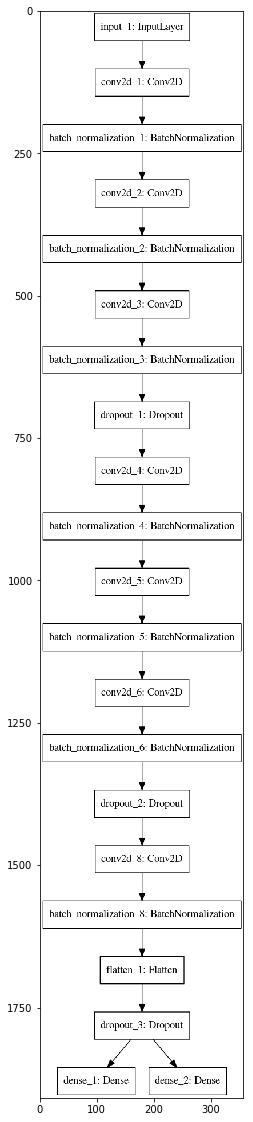

In [14]:
# Create the CNN and show a summary and a graph of its architecture
model = create_model()

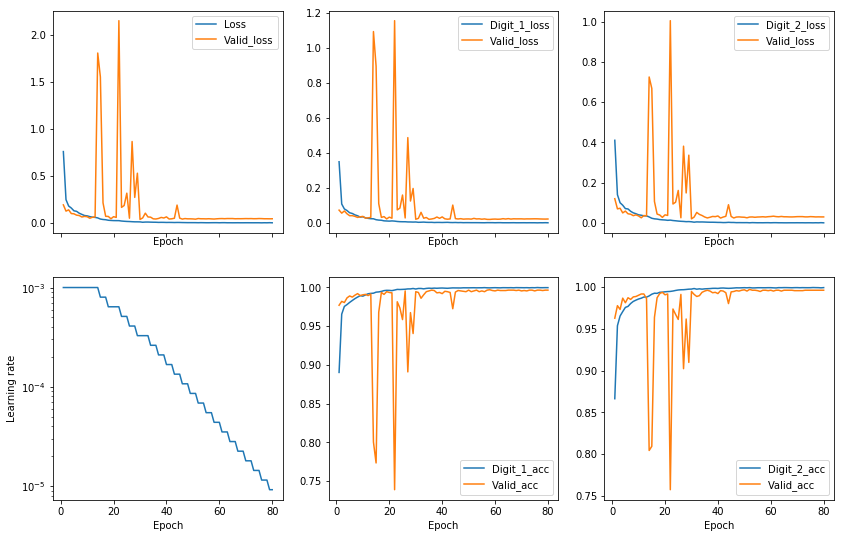

Epoch 00080: early stopping


In [15]:
# Run the model with the associated callbacks
history = model.fit(X_train, [y_train_digit_1, y_train_digit_2], epochs=epochs,
                    validation_split=0.05, callbacks=create_callbacks())

In [19]:
# Get the model predictions and convert them from OHE form to labels
y_pred = model.predict(X_test)
y_pred_digit_1 = np.argmax(y_pred[0], axis=1)
y_pred_digit_2 = np.argmax(y_pred[1], axis=1)
y_pred = np.vstack((y_pred_digit_1, y_pred_digit_2)).T

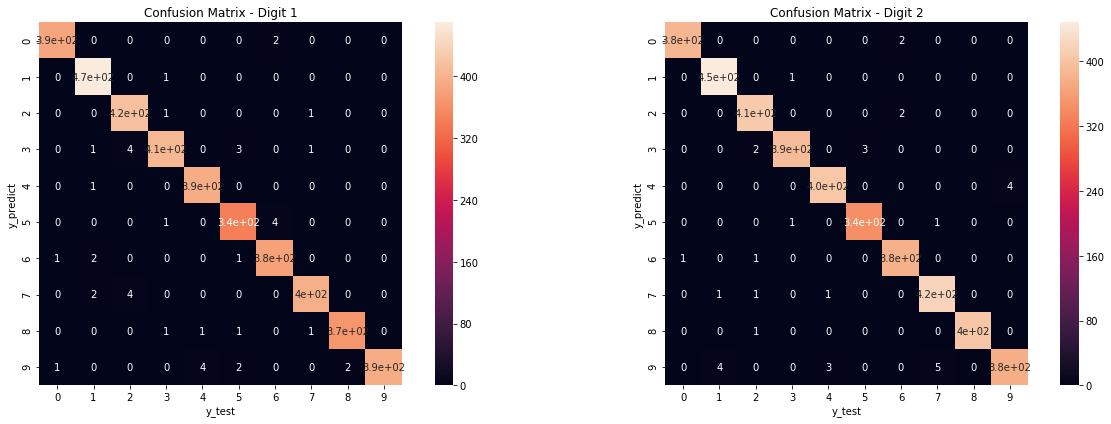

In [20]:
# Plot the confusion matrix for each digit
confusion_matrix_1, confusion_matrix_2 = confusion_matrix_analysis(y_test, y_pred_digit_1, y_pred_digit_2)

In [21]:
# Prepare the test labels for model evaluation
y_test_digit_1 = to_categorical(y_test.iloc[:, 0])
y_test_digit_2 = to_categorical(y_test.iloc[:, 1])

In [22]:
# Evaluate the model performance on the test images and display the results
test_scores = model.evaluate(X_test, [y_test_digit_1, y_test_digit_2] )

4000/4000 [==============================] - 6s 1ms/step


In [23]:
df_test_scores = pd.DataFrame(np.array(test_scores).reshape(1, -1), columns=model.metrics_names)
df_test_scores

,loss,dense_1_loss,dense_2_loss,dense_1_accuracy,dense_2_accuracy
0,0.090458,0.057004,0.033454,0.98925,0.9915


In [25]:
model.save('two_digit_mnist_model.h5')

## Conclusion

The model scores 98.9% and 99.1% accuracy for the two digits on the test set.
This is a little lower than the results on the training and validation sets ~99.8%. 
So, there is still some overfitting. However, for a very first run of the model the performance
is very good.

Further work will involve optimising the architecture of the CNN, hyper-parameter 
tuning and image augmentation.